In [1]:
import os
import time
import math
import random
import logging
import warnings
import operator
import numpy as np
from copy import copy
from typing import Tuple
from functools import reduce

import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torch.optim.adam import Adam
from torchvision import transforms
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from timm.models.vision_transformer import Block
from torchvision.utils import make_grid, save_image


import matplotlib
import seaborn as sns
from tqdm import tqdm
from einops import rearrange
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from monty.collections import AttrDict
import matplotlib.patheffects as PathEffects

from CNNUtils import train, test, valid, output_metric

%matplotlib inline

In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed_everything()

In [3]:
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.,), (1,))])

mnist_train = torchvision.datasets.MNIST('./data/', train=True, transform=trans, download=True)
mnist_train, mnist_val = random_split(mnist_train, [10000, 50000], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=mnist_train, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=mnist_val, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True)

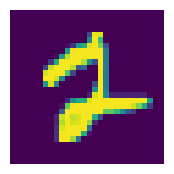

In [4]:
dataiter = iter(train_loader)
sample = next(dataiter)[0][0]
sample = sample.numpy().transpose(1, 2, 0)
plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

In [5]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M, )
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2, )  32

    pos = pos.reshape(-1)  # (M, )  169
    out = np.einsum('m, d -> md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=True):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # (H*W, D)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)  # (1+H*W, D)
    return pos_embed

In [6]:
class MAB(nn.Module):
    "Multihead Attention Block"
    def __init__(self, dim_Q, dim_K, dim_hidden, num_heads):
        super(MAB, self).__init__()
        self.dim_hidden = dim_hidden
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_hidden)
        self.fc_k = nn.Linear(dim_K, dim_hidden)
        self.fc_v = nn.Linear(dim_K, dim_hidden)
        self.fc_o = nn.Sequential(nn.Linear(dim_hidden, dim_Q), nn.Dropout(0.1))
        self.ln0 = nn.LayerNorm(dim_Q)
        self.ln1 = nn.LayerNorm(dim_K)
        self.ln2 = nn.LayerNorm(dim_Q)
        self.mlp = nn.Sequential(nn.Linear(dim_Q, 4*dim_Q), nn.GELU(), nn.Dropout(0.1), nn.Linear(4*dim_Q, dim_Q), nn.Dropout(0.1))

    def forward(self, Q, K):
        # LayerNorm
        Q_, K_ = self.ln0(Q), self.ln1(K)
        # Attention
        Q_, K_, V_ = self.fc_q(Q_), self.fc_k(K_), self.fc_v(K_)
        dim_head = self.dim_hidden // self.num_heads  # 64 // 4 = 16
        Q_ = torch.cat(Q_.split(dim_head, 2), 0)  # (4*B, K, 16) 
        K_ = torch.cat(K_.split(dim_head, 2), 0)  # (4*B, M, 16) 
        V_ = torch.cat(V_.split(dim_head, 2), 0)  # (4*B, M, 16) 
        A = torch.softmax(Q_.bmm(K_.transpose(1, 2)) / dim_head ** 0.5, 2)  # (4*B, K, M) 
        O = torch.cat(A.bmm(V_).split(Q.size(0), 0), 2)  # (B, K, 64)
        O = self.fc_o(O)
        # Residual
        O = Q + O
        # LayerNorm
        O_ = self.ln2(O)
        # Residual
        O = O + self.mlp(O_)
        return O  # (B, K, 128)


def random_masking(x, mask_ratio):
    N, L, D = x.shape  # batch, length, dim
    len_keep = int(L * (1 - mask_ratio))  
    noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]  (N, L)
    # sort noise for each sample
    ids_shuffle = torch.argsort(noise, dim=1)  # 从小到大排序，返回索引 (N, L)
    # keep the first subset
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
    return x_masked

In [7]:
class LeavesEncoder(nn.Module):
    def __init__(self, img_size=28, in_chans=1, embed_dim=128):
        super(LeavesEncoder, self).__init__()
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, 3, 2)  # (B, 128, 13, 13)
        self.num_patches = ((img_size - 3) // 2 + 1) ** 2  # 169
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim), requires_grad=False)  # (B, 169, 128)
        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.num_patches**.5), cls_token=False)  # (169, 128)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))  # (1, 169, 128)
        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))  # (embed_dim, in_chans, patch_size, patch_size)  (128, 1, 3, 3)

    def forward(self, imgs, mask_ratio=0.75):
        x = self.patch_embed(imgs)  # (B, 128, 13, 13)
        x = rearrange(x, 'b c h w -> b (h w) c')  # (B, 169, 128)
        # add pos embed w/o cls token
        x = x + self.pos_embed  # (B, 169, 128)
        if self.training:
            x = random_masking(x, mask_ratio)  # (B, 84, 128)
        return x


class InternalsEncoder(nn.Module):
    def __init__(self, dim_input=128, embed_dim=128):
        super(InternalsEncoder, self).__init__()
        self.n_internals = int((13 - 3) / 2 + 1) ** 2  # 36
        self.I = nn.Parameter(torch.zeros(1, 1, embed_dim))  # (1, 1, 128)
        self.internals_embed = MAB(embed_dim, dim_input, dim_hidden=64, num_heads=4)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_internals, embed_dim), requires_grad=False)  # (B, 36, 128)
        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.n_internals**.5), cls_token=False)  # (36, 128)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))  # (1, 36, 128)
        nn.init.xavier_uniform_(self.I)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, mask_ratio=0.75):
        internals_tokens = self.I.repeat(x.shape[0], self.n_internals, 1)  # (B, 36, 128)
        internals_tokens = internals_tokens + self.pos_embed
        # Inducing Internals
        x = self.internals_embed(internals_tokens, x)  # (B, 36, 128)
        if self.training:
            x = random_masking(x, mask_ratio)  # (B, 9, 128)
        return x


class TopsEncoder(nn.Module):
    def __init__(self, dim_input=128, embed_dim=128):
        super(TopsEncoder, self).__init__()
        self.n_tops = int((6 - 3) / 1 + 1) ** 2  # 16
        self.I = nn.Parameter(torch.zeros(1, 1, embed_dim))  # (1, 1, 128)
        self.tops_embed = MAB(embed_dim, dim_input, dim_hidden=64, num_heads=4)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_tops, embed_dim), requires_grad=False)  # (B, 16, 128)
        self.initialize_weights()

    def initialize_weights(self):
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.n_tops**.5), cls_token=False)  # (16, 128)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))  # (1, 16, 128)
        nn.init.xavier_uniform_(self.I)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x, mask_ratio=0.75):
        tops_tokens = self.I.repeat(x.shape[0], self.n_tops, 1)  # (B, 16, 128)
        tops_tokens = tops_tokens + self.pos_embed
        # Inducing Tops
        x = self.tops_embed(tops_tokens, x)  # (B, 16, 128)
        if self.training:
            x = random_masking(x, mask_ratio)  # (B, 4, 128)
        return x


class RootEncoder(nn.Module):
    def __init__(self, dim_input=128, depth=4, num_heads=8):
        super(RootEncoder, self).__init__()
        self.norm = nn.LayerNorm(dim_input)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim_input))
        self.cls_tokens_pos_embed = nn.Parameter(torch.zeros(1, 1, dim_input), requires_grad=False)
        nn.init.normal_(self.cls_token, std=.02)
        self.blocks = nn.ModuleList([Block(dim_input, num_heads, qkv_bias=True) for _ in range(depth)])
        
    def forward(self, x):
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1) + self.cls_tokens_pos_embed  # (B, 1, 128)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 1+4, 128)
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x[:, 0, :]
        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self, output_shape=[1, 28, 28], root_dim=128):
        super(Decoder, self).__init__()
        self.output_shape = output_shape
        self.root_dim = root_dim
        
        self.fc = nn.Sequential(nn.Linear(self.root_dim, 32*3*3), nn.BatchNorm1d(32*3*3), nn.ReLU())
        self.trans_conv = nn.Sequential(nn.ConvTranspose2d(32, 128, 3, stride=2), nn.BatchNorm2d(128), nn.ReLU(), # (..., 7, 7)
                                        nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(), # (..., 13, 13)
                                        nn.ConvTranspose2d(64, self.output_shape[0], 4, stride=2), nn.Sigmoid())  # (batch_size, 1, 28, 28)
        
    def forward(self, codings_in_batch_order):  # x: (batch, 38)
        h = self.fc(codings_in_batch_order)
        h = h.view(-1, 32, 3, 3)
        return self.trans_conv(h)


class MaskedTree(nn.Module):
    def __init__(self, input_shape=[1, 28, 28], root_dim=128):
        super(MaskedTree, self).__init__()
        self.leaves_encoder = LeavesEncoder()
        self.internals_encoder = InternalsEncoder()
        self.tops_encoder = TopsEncoder()
        self.roots_encoder = RootEncoder()
        self.decoder = Decoder(input_shape, root_dim)

    def forward(self, imgs):
        leaves = self.leaves_encoder(imgs)
        internals = self.internals_encoder(leaves)
        tops = self.tops_encoder(internals)
        codings = self.roots_encoder(tops)
        recons = self.decoder(codings)
        return recons, codings

In [9]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)


class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


def pretrain(model, criterion, train_loader, device):
    model.train()
    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    train_len = len(train_loader)
    path = './model/maskedtree.pt'
    for epoch in range(200):
        objs = AverageMeter()
        for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
            image = image.to(device)
            optimizer.zero_grad()
            recons, _ = model(image)
            loss = criterion(recons, image)
            loss.backward()
            optimizer.step()
            n = image.shape[0]
            objs.update(loss.data, n)  
            if (batch_idx + 1) == len(train_loader):
                print('epoch: {}, loss: {:.4f}'.format(epoch+1, objs.avg))  
        scheduler.step()
    torch.save(model.state_dict(), path)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

maskedtree = MaskedTree()
maskedtree = maskedtree.to(device)
criterion = nn.MSELoss()

In [11]:
model_summary(maskedtree)

leaves_encoder.patch_embed.weight: 128x1x3x3 = 1152
leaves_encoder.patch_embed.bias: 128
internals_encoder.I: 1x1x128 = 128
internals_encoder.internals_embed.fc_q.weight: 64x128 = 8192
internals_encoder.internals_embed.fc_q.bias: 64
internals_encoder.internals_embed.fc_k.weight: 64x128 = 8192
internals_encoder.internals_embed.fc_k.bias: 64
internals_encoder.internals_embed.fc_v.weight: 64x128 = 8192
internals_encoder.internals_embed.fc_v.bias: 64
internals_encoder.internals_embed.fc_o.0.weight: 128x64 = 8192
internals_encoder.internals_embed.fc_o.0.bias: 128
internals_encoder.internals_embed.ln0.weight: 128
internals_encoder.internals_embed.ln0.bias: 128
internals_encoder.internals_embed.ln1.weight: 128
internals_encoder.internals_embed.ln1.bias: 128
internals_encoder.internals_embed.ln2.weight: 128
internals_encoder.internals_embed.ln2.bias: 128
internals_encoder.internals_embed.mlp.0.weight: 512x128 = 65536
internals_encoder.internals_embed.mlp.0.bias: 512
internals_encoder.internals

In [12]:
path = './model/maskedtree.pt'

maskedtree.load_state_dict(torch.load(path))
maskedtree.eval()
print('done')

done


In [13]:
dataiter = iter(test_loader)
x_test, y_test = next(dataiter)  # 64, 3, 32, 32

x_test_original = x_test[:20]
x_test = x_test_original.numpy().transpose(0, 2, 3, 1)
y_test = y_test[:20].numpy()

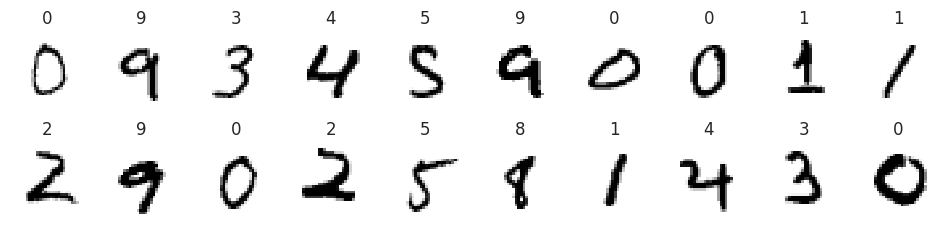

In [24]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

n_rows = 2
n_cols = 10
fig = plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_test[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig('./mcnn_originals.pdf', bbox_inches='tight', dpi=300)

In [15]:
return_tuple = maskedtree(x_test_original.cuda())
recons = return_tuple[0]
recons = recons.detach().cpu().numpy()
recons = recons.transpose(0, 2, 3, 1)

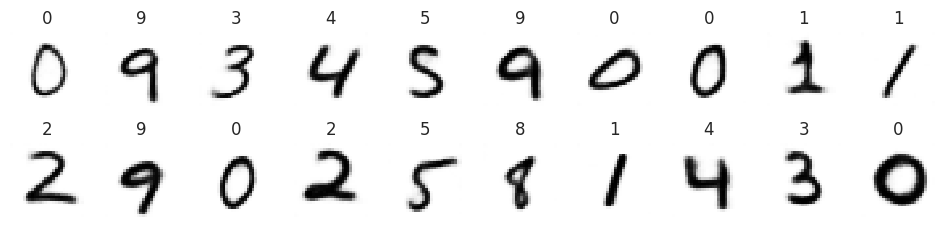

In [25]:
n_rows = 2
n_cols = 10
fig = plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(recons[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig('./mcnn_reconstructions.pdf', bbox_inches='tight', dpi=300)

In [17]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    
    # We create a scatter plot.
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int_)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i+1), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    fig.savefig('./tsne_mcnn.pdf', dpi=300, bbox_inches='tight')

In [18]:
train_codings = []
train_tar = []
for batch_idx, (image, label) in enumerate(train_loader):
    with torch.no_grad():
        image = image.to(device)
        label = label.to(device)
        return_tuple = maskedtree(image)
        codings = return_tuple[1]
    train_codings.append(codings.cpu().data)
    train_tar.append(label.cpu().data)

x_train = torch.concat(train_codings)
y_train = torch.concat(train_tar)

x_train_numpy = x_train.numpy()
y_train_numpy = y_train.numpy()

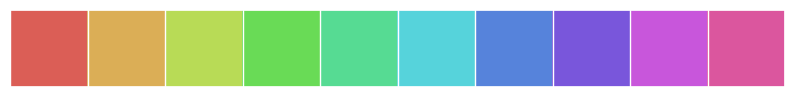

In [19]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

palette = sns.color_palette("hls", 10)
sns.palplot(palette)

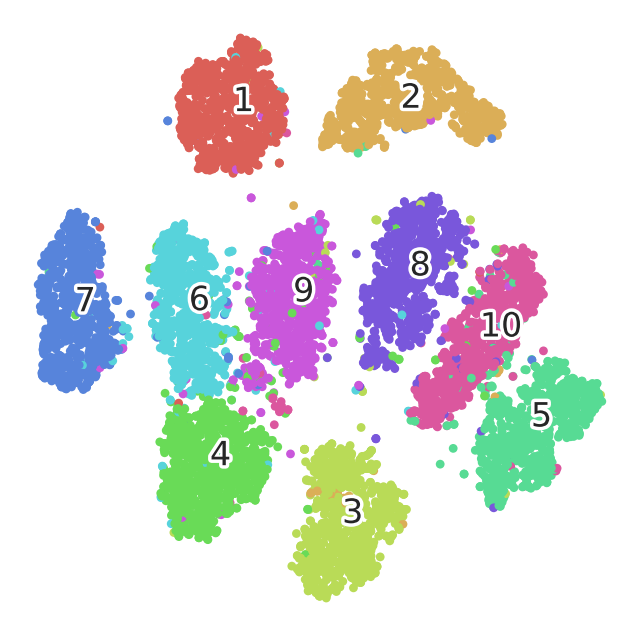

In [20]:
tsne_proj = TSNE(random_state=42).fit_transform(x_train_numpy)

scatter(tsne_proj, y_train_numpy)

## Metrics

In [21]:
def mean_distance(codings, label, c=10):
    codings_per_class = []  # [(16, ) * 10]
    for i in range(c):
        codings_per_class.append(codings[label == i, :])
    centers = [torch.mean(codings_per_class[i], 0) for i in range(c)]
    
    inter_class_distance = torch.tensor(0.)
    for k in range(c - 1):
        for t in range(k + 1, c):
            inter_class_distance += torch.dist(centers[k], centers[t], p=2)
    mean_inter_class_distance = inter_class_distance / (c * (c - 1) / 2)
    
    intra_class_distance = torch.tensor(0.)
    for i in range(c):
        per_intra_class_distance = torch.tensor(0.)
        per_class_features = codings_per_class[i]
        center_feature = centers[i]
        num = per_class_features.size(0)
        for j in range(num):
            per_intra_class_distance += torch.dist(per_class_features[j], center_feature, p=2)
        per_intra_class_distance = per_intra_class_distance / num
        
        intra_class_distance += per_intra_class_distance
    mean_intra_class_distance = intra_class_distance / c
    return mean_intra_class_distance, mean_inter_class_distance

In [22]:
mean_intra_class_distance, mean_inter_class_distance = mean_distance(x_train, y_train)

mean_intra_class_distance, mean_inter_class_distance

(tensor(5.2987), tensor(5.2004))

## Fine-tuning

In [25]:
class NewLeavesEncoder(LeavesEncoder):
    def forward(self, imgs):
        x = self.patch_embed(imgs)  # (B, 128, 13, 13)
        x = rearrange(x, 'b c h w -> b (h w) c')  # (B, 169, 128)
        # add pos embed w/o cls token
        x = x + self.pos_embed  # (B, 169, 128)
        return x


class NewInternalsEncoder(InternalsEncoder):
    def forward(self, x):
        internals_tokens = self.I.repeat(x.shape[0], self.n_internals, 1)  # (B, 36, 128)
        internals_tokens = internals_tokens + self.pos_embed
        # Inducing Internals
        x = self.internals_embed(internals_tokens, x)  # (B, 36, 128)
        return x


class NewTopsEncoder(TopsEncoder):
    def forward(self, x):
        tops_tokens = self.I.repeat(x.shape[0], self.n_tops, 1)  # (B, 16, 128)
        tops_tokens = tops_tokens + self.pos_embed
        # Inducing Tops
        x = self.tops_embed(tops_tokens, x)  # (B, 16, 128)
        return x


class NewMaskedTree(nn.Module):
    def __init__(self, input_shape=[1, 28, 28], root_dim=128, n_classes=10):
        super(NewMaskedTree, self).__init__()
        self.leaves_encoder = NewLeavesEncoder()
        self.internals_encoder = NewInternalsEncoder()
        self.tops_encoder = NewTopsEncoder()
        self.roots_encoder = RootEncoder()
        self.cls_head = nn.Sequential(nn.Linear(root_dim, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64, n_classes))

    def forward(self, x):
        leaves = self.leaves_encoder(x)
        internals = self.internals_encoder(leaves)
        tops = self.tops_encoder(internals)
        codings = self.roots_encoder(tops)
        preds = self.cls_head(codings)
        return preds

In [26]:
maskedtree = NewMaskedTree()

path = './model/maskedtree.pt'
pre_weights = torch.load(path, map_location='cpu')
pre_dict = {k: v for k, v in pre_weights.items() if k in maskedtree.state_dict()}
missing_keys, unexpected_keys = maskedtree.load_state_dict(pre_dict, strict=False)

In [27]:
for param in maskedtree.parameters():
    param.requires_grad = False

for param in maskedtree.roots_encoder.blocks[-1].parameters():
    param.requires_grad = True

for param in maskedtree.cls_head.parameters():
    param.requires_grad = True

In [28]:
model_summary(maskedtree)

roots_encoder.blocks.3.norm1.weight: 128
roots_encoder.blocks.3.norm1.bias: 128
roots_encoder.blocks.3.attn.qkv.weight: 384x128 = 49152
roots_encoder.blocks.3.attn.qkv.bias: 384
roots_encoder.blocks.3.attn.proj.weight: 128x128 = 16384
roots_encoder.blocks.3.attn.proj.bias: 128
roots_encoder.blocks.3.norm2.weight: 128
roots_encoder.blocks.3.norm2.bias: 128
roots_encoder.blocks.3.mlp.fc1.weight: 512x128 = 65536
roots_encoder.blocks.3.mlp.fc1.bias: 512
roots_encoder.blocks.3.mlp.fc2.weight: 128x512 = 65536
roots_encoder.blocks.3.mlp.fc2.bias: 128
cls_head.0.weight: 64x128 = 8192
cls_head.0.bias: 64
cls_head.3.weight: 10x64 = 640
cls_head.3.bias: 10

Total Trainable Parameters: 207178


In [29]:
maskedtree = maskedtree.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(maskedtree.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [30]:
trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.,), (1,))])

mnist_train = torchvision.datasets.MNIST('./data/', train=True, transform=trans, download=True)
mnist_train, mnist_val = random_split(mnist_train, [100, 59900], generator=torch.Generator().manual_seed(42))

mnist_test = torchvision.datasets.MNIST('./data/', train=False, transform=torchvision.transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=mnist_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True)

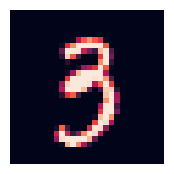

In [31]:
dataiter = iter(train_loader)
sample = next(dataiter)[0][0]
sample = sample.numpy().transpose(1, 2, 0)
plt.figure(figsize=(2, 2))
plt.imshow(sample)
plt.axis('off')
plt.show()

In [32]:
for _, (data, label) in enumerate(train_loader):
    print(label)

tensor([1, 3, 9, 5, 2, 8, 4, 2, 6, 1, 6, 6, 0, 4, 3, 9, 3, 4, 7, 6, 2, 1, 3, 1,
        9, 6, 3, 7, 6, 0, 1, 4])
tensor([7, 1, 0, 2, 6, 0, 4, 6, 2, 5, 1, 8, 9, 4, 5, 6, 3, 8, 1, 5, 2, 5, 7, 3,
        1, 1, 7, 2, 2, 9, 7, 6])
tensor([5, 6, 0, 5, 9, 0, 6, 0, 6, 3, 2, 8, 9, 3, 5, 2, 3, 3, 6, 7, 7, 2, 8, 9,
        9, 9, 9, 7, 1, 9, 2, 1])
tensor([4, 7, 1, 7])


In [33]:
tic = time.time()
acc_list = [0.00]
path = './model/finetune_mt.pt'

for epoch in range(200):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(maskedtree, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(maskedtree, test_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to finetune_mt.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(maskedtree.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]
  
toc = time.time()
print("Training Time: {:.2f} seconds".format(toc-tic))
print("*******************************************************")

Epoch: 001 - train_loss: 2.2841 - train_acc: 14.0000 - valid_loss: 2.2613 - valid_acc: 14.5200
val_acc improved from 0.0000 to 14.5200, saving model to finetune_mt.pt
Epoch: 002 - train_loss: 2.1495 - train_acc: 26.0000 - valid_loss: 2.1892 - valid_acc: 28.0400
val_acc improved from 14.5200 to 28.0400, saving model to finetune_mt.pt
Epoch: 003 - train_loss: 2.0284 - train_acc: 38.0000 - valid_loss: 2.1144 - valid_acc: 37.7900
val_acc improved from 28.0400 to 37.7900, saving model to finetune_mt.pt
Epoch: 004 - train_loss: 1.9232 - train_acc: 52.0000 - valid_loss: 2.0240 - valid_acc: 42.9300
val_acc improved from 37.7900 to 42.9300, saving model to finetune_mt.pt
Epoch: 005 - train_loss: 1.7965 - train_acc: 56.0000 - valid_loss: 1.8974 - valid_acc: 50.7800
val_acc improved from 42.9300 to 50.7800, saving model to finetune_mt.pt
Epoch: 006 - train_loss: 1.6639 - train_acc: 66.0000 - valid_loss: 1.7608 - valid_acc: 59.1600
val_acc improved from 50.7800 to 59.1600, saving model to finetune

In [34]:
path = './model/finetune_mt.pt'

maskedtree.load_state_dict(torch.load(path))
maskedtree.eval()
print('done')

done


In [35]:
tar_test, pre_test = test(maskedtree, valid_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [36]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 88.35, AA: 88.15, Kappa: 0.8705
*******************************************************************
Recal: [94.96 97.52 89.79 84.74 83.38 80.82 96.05 88.39 75.69 90.2 ]
*******************************************************************
